### **INSPACE OBJECT DETECTION AND TRACKING**

**Objective**

- The project aims at detecting objects that are essential on a daily basis for any end-user be it in a domestic space or a commercial space. The intended solution was to provide the user with info on the location of the objects that the users want to track.

- Since the objective of our use case is to detect objects in real-time scenarios we opted to build and compare Single Shot Detectors using state-of-the-art pre-trained models on the basis of mean Average Precision(mAP), mean Average Recall (mAR) and Inference speed. 

### **Data Preparation**

**This Notebook is solely created to showcase the data preparation steps required to perform Object Detection using Tensorflow Object Detection API.**

#### **Setting up environment**

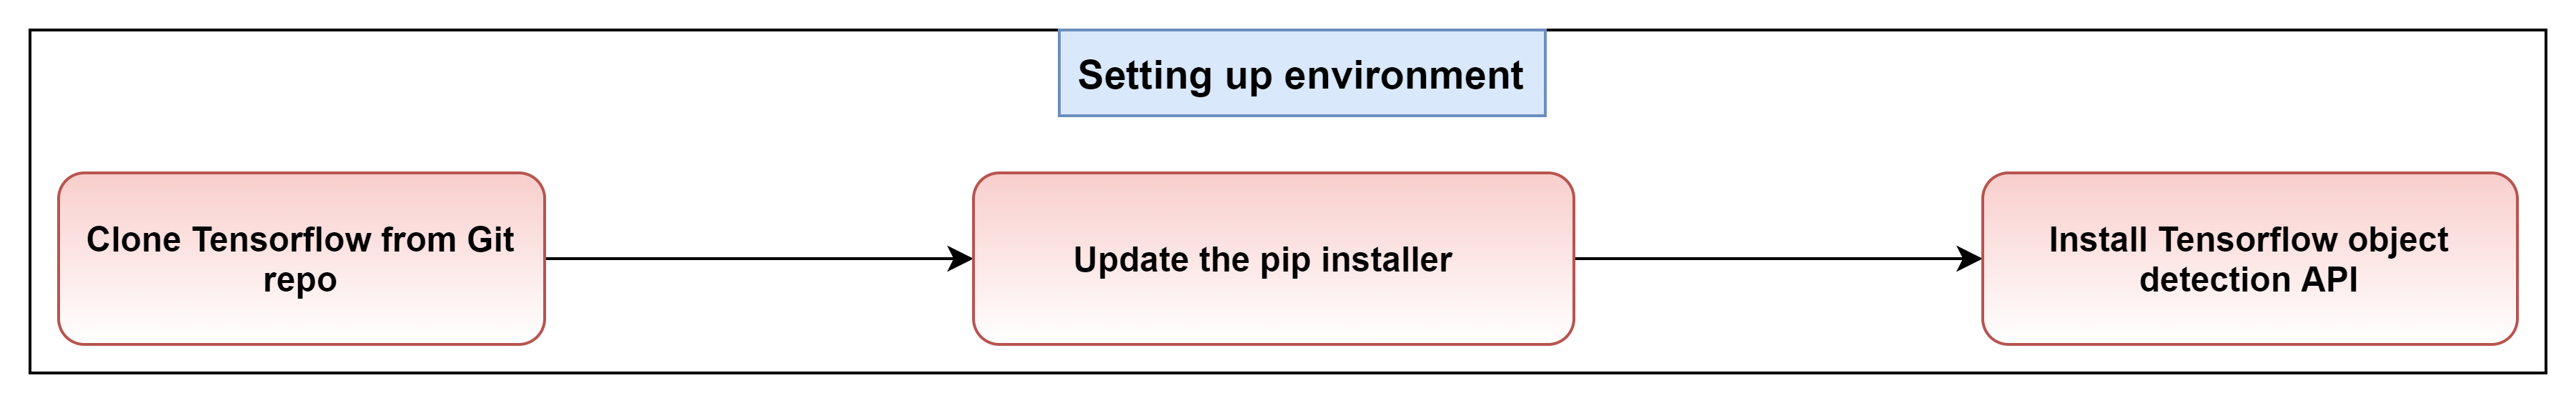

In [ ]:
#Clone github repository
#!git clone https://github.com/tensorflow/models      # Repo added to the drive

In [ ]:
#Upgrade pip package
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


**Importing required Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf

**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os - To work with the folders in drive
import os

In [ ]:
# os.chdir("path") # changes the current working directory to the path specified
os.chdir(r"/content/drive/MyDrive/Capstone_Project_Group_Practice_files/Object_Detection_15_Classes")

**Install TensorFlow Object Detection API**

In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver .

In [ ]:
#Check if Object Detection API is installed
!pip list | grep object-detection

object-detection              0.1


In [ ]:
# Creating a folder too save the preprocessed files 
!mkdir detection

# Navigating to the project folder
%cd detection

#### **Creating XML Files**

***To solve the Object Detection problem, we need images, class labels and bounding boxes of each object. Usually the object location in images are represented by a rectangular box surrounding the object which are called Bounding Boxes, and we have annotated the images using LabelImg tool.***


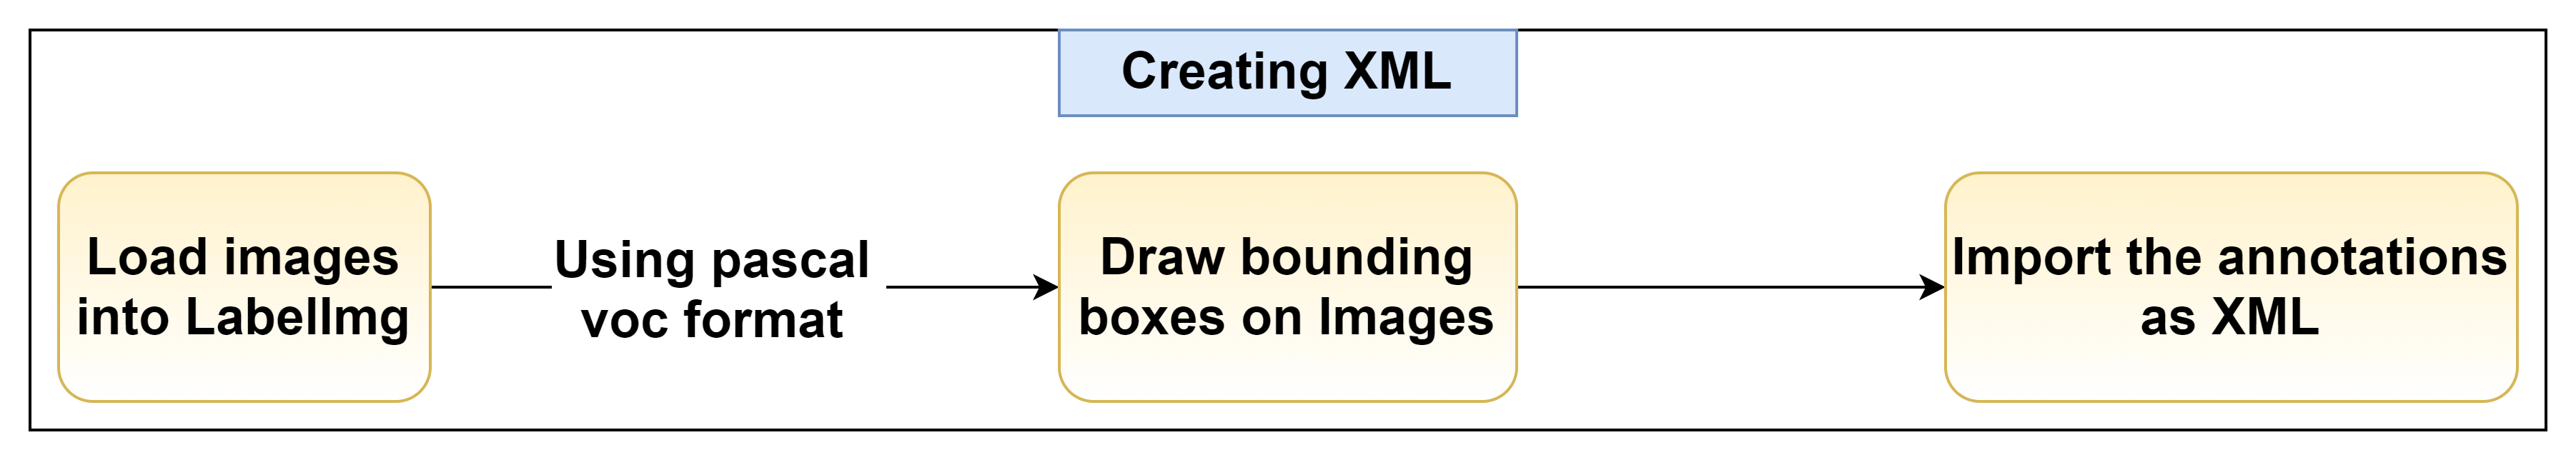

In [ ]:
# Path to XMls and the respective Images
img_path = '/content/drive/MyDrive/Capstone_Project_Group_Practice_files/Complete_Image_Dataset/format_convertedImages'
xml_path = '/content/drive/MyDrive/Capstone_Project_Group_Practice_files/Object_Detection_Test_Code/xml_files'

#### Converting XMLs to CSVs

**For the ease of data preprocessing and manipulation, the xml files are converted into a single CSV file, so that the annotations can be read with the help of the pandas library.**

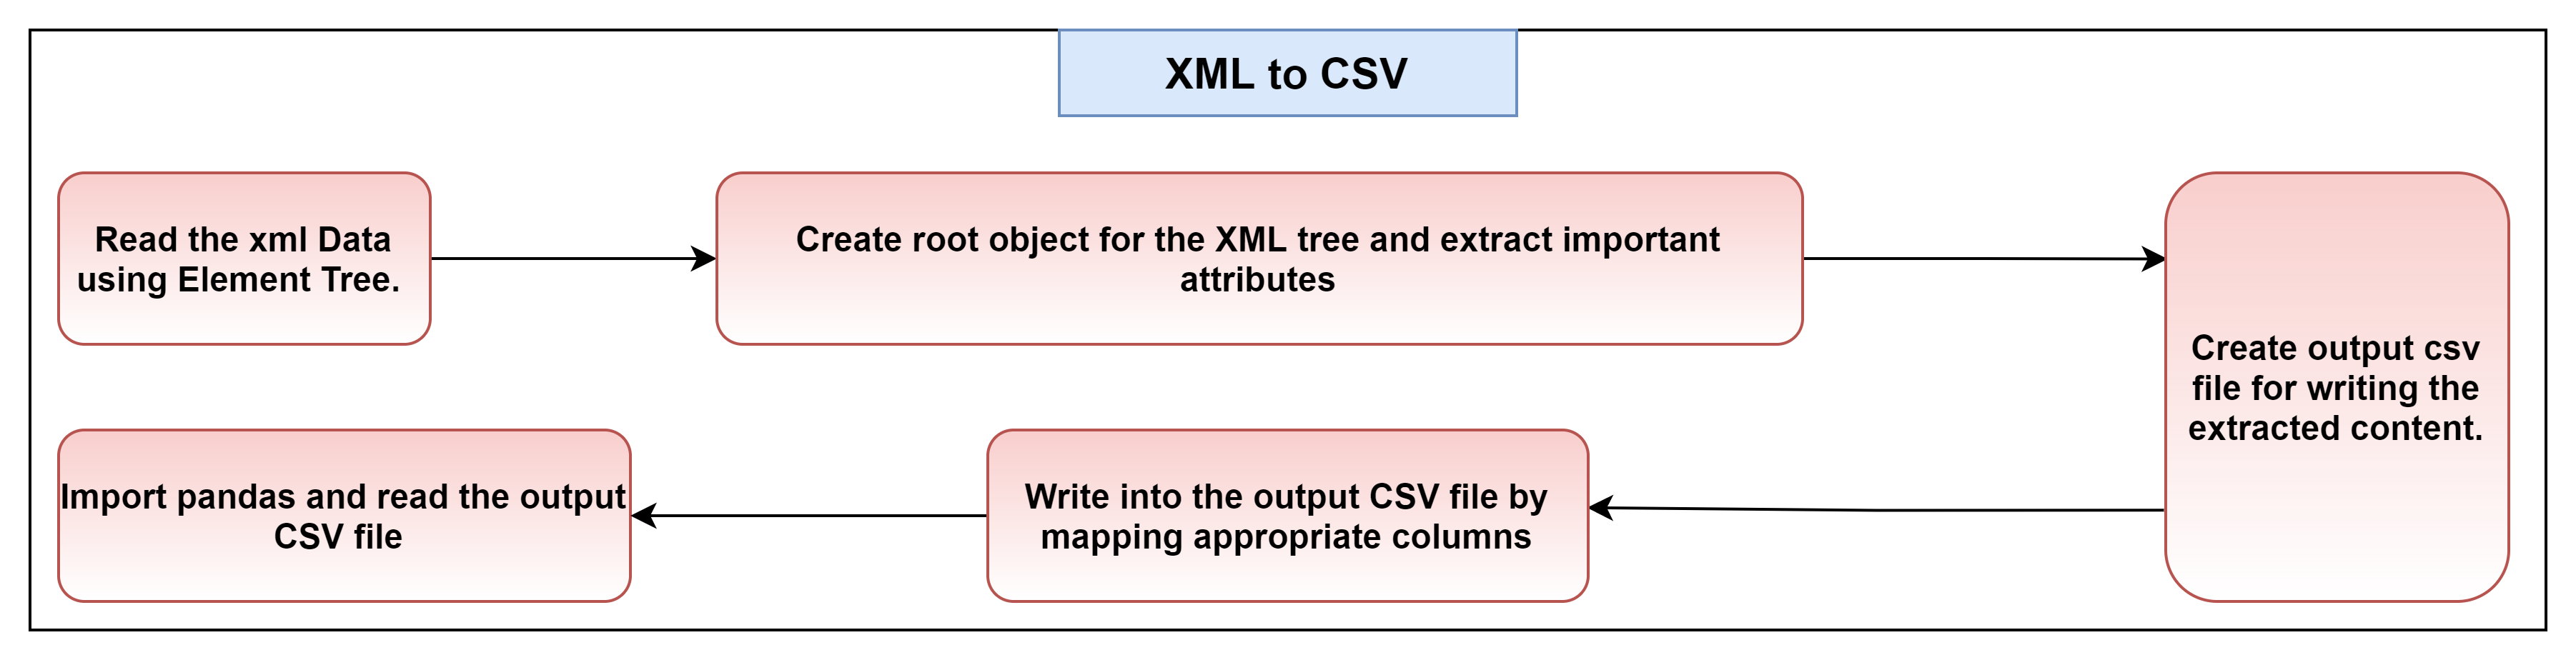


Generating CSV file from all XML files is done using a python script. The script takes two parameters

-i : indicating path of XML files 

-o : indicating what name should be given to CSV output file and where it should be stored. 

In [ ]:
# Convert XML to CSV

#Running the script with options
!python xml_to_csv.py -i {xml_path} -o detection_data.csv

Successfully converted xml to csv.


In [ ]:
# Load csv as Dataframe

import pandas as pd
df = pd.read_csv('detection_data.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Rings 0027.jpg,262,262,Rings,35,48,225,215
1,Rings 0028.jpg,262,262,Rings,27,42,235,215
2,Rings 0029.jpg,262,262,Rings,36,37,223,195
3,Rings 0030.jpg,690,681,Rings,194,186,490,471
4,Rings 0030.jpg,690,681,Rings,119,475,418,600


In [ ]:
#How many object across all images
df.shape

(1901, 8)

- **A Total of 15 classes consisting of 1500 images were collected and these 1500 images have 1901 objects in them.**

In [ ]:
#List of labels
df['class'].unique()

array(['Rings', 'Earrings', 'ID Card', 'Wristwatch', 'Remote',
       'Mobile Charger', 'pendrive', 'Torchlight', 'bottles', 'Bracelet',
       'Earphones', 'Mobile', 'Spectacles', 'Belt', 'Wallet'],
      dtype=object)

In [ ]:
#Number of labels
len(df['class'].unique())

15

In [ ]:
# We will need to Label encode classes e.g assign a unique index number for each class
#Use Label encoder available in Scikit Learn
from sklearn import preprocessing

In [ ]:
#Label Encode class and add a 'label' column to the dataframe
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['class'])
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,label
0,Rings 0027.jpg,262,262,Rings,35,48,225,215,8
1,Rings 0028.jpg,262,262,Rings,27,42,235,215,8
2,Rings 0029.jpg,262,262,Rings,36,37,223,195,8
3,Rings 0030.jpg,690,681,Rings,194,186,490,471,8
4,Rings 0030.jpg,690,681,Rings,119,475,418,600,8


In [ ]:
#unique values in the label
df.label.unique()

array([ 8,  3,  4, 12,  7,  6, 14, 10, 13,  1,  2,  5,  9,  0, 11])

In [ ]:
#Object detection API expects index to start from 1 (and not 0)
df['label'] = df['label'] + 1
df.label.unique()

array([ 9,  4,  5, 13,  8,  7, 15, 11, 14,  2,  3,  6, 10,  1, 12])

In [ ]:
#Dataframe should have label column now
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,label
0,Rings 0027.jpg,262,262,Rings,35,48,225,215,9
1,Rings 0028.jpg,262,262,Rings,27,42,235,215,9
2,Rings 0029.jpg,262,262,Rings,36,37,223,195,9
3,Rings 0030.jpg,690,681,Rings,194,186,490,471,9
4,Rings 0030.jpg,690,681,Rings,119,475,418,600,9


In [ ]:
#Create a dictionary of Label and Class. This will be useful for building our second input to Model training
label_class_dict = dict(zip(df['label'], df['class']))
print(label_class_dict)

{9: 'Rings', 4: 'Earrings', 5: 'ID Card', 13: 'Wristwatch', 8: 'Remote', 7: 'Mobile Charger', 15: 'pendrive', 11: 'Torchlight', 14: 'bottles', 2: 'Bracelet', 3: 'Earphones', 6: 'Mobile', 10: 'Spectacles', 1: 'Belt', 12: 'Wallet'}


In [ ]:
#Save label dictionary for model prediction
import pickle

label_file_path = '/content/drive/MyDrive/Capstone_Project_Group_Practice_files/Object_Detection_15_Classes/detection/label_class.pkl'

with open(label_file_path,'wb') as file:
    pickle.dump(label_class_dict, file)

####**Splitting the data between train and test**

- First we have to split images between training and test. Then we can use that information to split dataframe between training and test. This will make sure objects from same image are not split between training and test.

In [ ]:
#Get information on all images
all_classes = df['filename'].unique()
all_classes.shape

(1500,)

In [ ]:
#Split images between training and test
import numpy as np

#80% of the data will be used for training
mask = np.random.rand(all_classes.shape[0]) < 0.8

#Get Training and Test images
train_images = all_classes[mask]
test_images = all_classes[~mask] 

In [ ]:
#Check number of images in training and test
train_images.shape, test_images.shape

((1178,), (322,))

In [ ]:
train_images[:10]

array(['Rings 0027.jpg', 'Rings 0028.jpg', 'Rings 0029.jpg',
       'Rings 0032.jpg', 'Rings 0034.jpg', 'Rings 0036.jpg',
       'Rings 0037.jpg', 'Rings 0038.jpg', 'Rings 0039.jpg',
       'Rings 0040.jpg'], dtype=object)

In [ ]:
#Split dataframe between training and test
train_df = df[df['filename'].isin(train_images)]
test_df = df[df['filename'].isin(test_images)]

In [ ]:
train_df.shape, test_df.shape

((1495, 9), (406, 9))

#### Visualizing the data

Number of objects 1


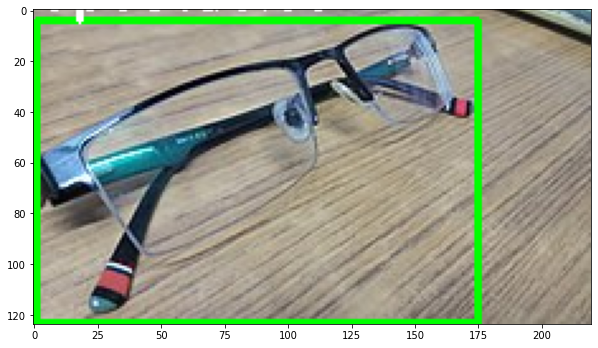

In [ ]:
#We will use opencv and matplotlib
from matplotlib import pyplot as plt
import cv2

#Pickup a random image number
img_num = np.random.randint(0, df.shape[0])

#Read the image
img_file = df.loc[img_num,'filename']
img = cv2.imread(img_path + '/' + img_file)

#Find all rows which have same file name
rows_with_file = df[df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
print('Number of objects', len(rows_with_file))
for i in rows_with_file:

    #Get bounding box
    xmin, ymin, xmax, ymax = df.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    #Get Label
    label = df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.show()

In [ ]:
# Saving training and test data as csv
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

#### **Creating TF Records**

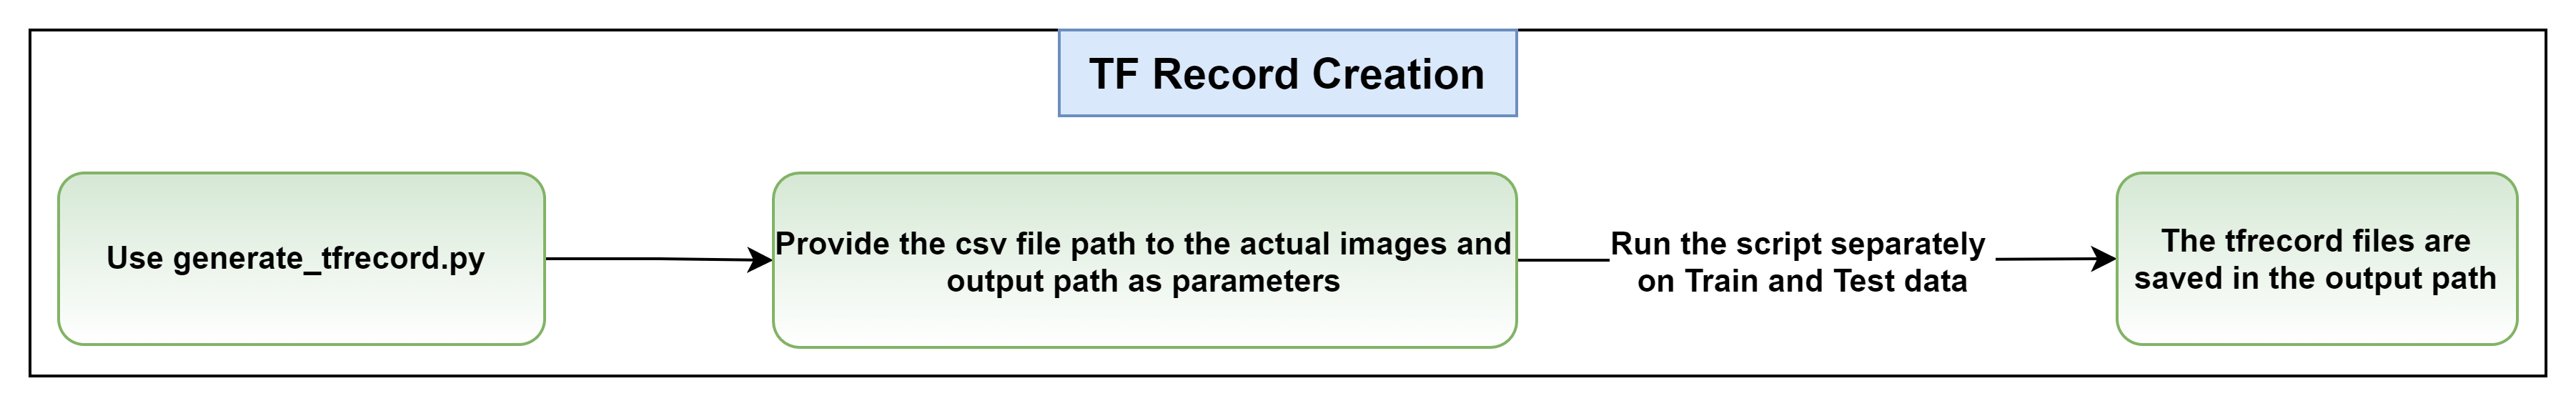

**TensorFlow object detection API doesn’t take csv files as an input, it needs tfrecord files to train the model. A TFRecord is a kind of binary file that TensorFlow uses to store binary data.**


In [ ]:
#generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv  --img_path={img_path} --output_path=train.tfrecord

2021-10-22 05:56:57.625346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 05:56:57.634513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 05:56:57.635282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Successfully created the TFRecords: /content/drive/.shortcut-targets-by-id/1NVkW79pvdYssqEKCwdyuNSrfx_b5t5Y1/Capstone_Project_Group_Practice_files/Object_Detection_15_Classes/detection/train.tfrecord


In [ ]:
#generate tfrecord for test data
!python generate_tfrecord.py --csv_input=test.csv  --img_path={img_path} --output_path=test.tfrecord

2021-10-22 06:01:43.727268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 06:01:43.736174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 06:01:43.737015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Successfully created the TFRecords: /content/drive/.shortcut-targets-by-id/1NVkW79pvdYssqEKCwdyuNSrfx_b5t5Y1/Capstone_Project_Group_Practice_files/Object_Detection_15_Classes/detection/test.tfrecord


In [ ]:
# Create Label Mapping File

#Dict which was created earlier will be used for building Label Mapping file
label_class_dict

{1: 'Belt',
 2: 'Bracelet',
 3: 'Earphones',
 4: 'Earrings',
 5: 'ID Card',
 6: 'Mobile',
 7: 'Mobile Charger',
 8: 'Remote',
 9: 'Rings',
 10: 'Spectacles',
 11: 'Torchlight',
 12: 'Wallet',
 13: 'Wristwatch',
 14: 'bottles',
 15: 'pendrive'}

In [ ]:
#Build a pbtxt label file using label and class name
#This is required by Object detection API to map the class names with object labels
#You can prepare it manually as well.

pbtxt_file_txt = ''
for label in sorted(label_class_dict.keys()):
    
    pbtxt_file_txt += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"

with open('label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_txt)

In [ ]:
#Review the file content
!cat label_map.txt

item {
  id: 1
  name: 'Belt'
}

item {
  id: 2
  name: 'Bracelet'
}

item {
  id: 3
  name: 'Earphones'
}

item {
  id: 4
  name: 'Earrings'
}

item {
  id: 5
  name: 'ID Card'
}

item {
  id: 6
  name: 'Mobile'
}

item {
  id: 7
  name: 'Mobile Charger'
}

item {
  id: 8
  name: 'Remote'
}

item {
  id: 9
  name: 'Rings'
}

item {
  id: 10
  name: 'Spectacles'
}

item {
  id: 11
  name: 'Torchlight'
}

item {
  id: 12
  name: 'Wallet'
}

item {
  id: 13
  name: 'Wristwatch'
}

item {
  id: 14
  name: 'bottles'
}

item {
  id: 15
  name: 'pendrive'
}

